<a href="https://colab.research.google.com/github/adrianstop/EmTrack/blob/main/emTrack_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Transportation Mode Classification

## Setup Python Environment

The next cell sets up the dependencies required for the notebook.

In [1]:
# Setup environment
!apt-get -qq install xxd unzip
!pip install pandas numpy matplotlib
!pip install tensorflow
!pip install tinymlgen
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2225 sha256=346de9794b0230e8a6096c44eed0d581ff2a31d6f92a87645d17323c988598f0
  Stored in directory: /root/.cache/pip/wheels/37/f6/60/b245c012a863872e10d737539c1e3f2db0499dfb6735f48494
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8897 sha256=2e04886db7b21b715be9644a5af8173d28c30fc37ac82dbea4af47d8d8f3a79d
  Stored in directory: /root/.cache/pip/wheels/26/28/f7/f47d7ecd9ae44c4457e72c8bb617ef18ab332ee2b2a1047e87
Successfully built tinymlgen hexdump
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

## Import Python libraries


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import visualkeras
import os
import scipy.io

## Get Data
The data is imported from the SHL dataset: http://www.shl-dataset.org/


In [3]:
# Download HTC dataset
# !wget https://storage.googleapis.com/google-code-archive-source/v2/code.google.com/transportation-mode-detection/source-archive.zip
# !unzip source-archive.zip
# !rm -rf source-archive.zip
# !unzip transportation-mode-detection/htc_transportation.zip
# !rm -rf transportation-mode-detection

# Fetch processed SHL data
!wget https://github.com/adrianstop/EmTrack/raw/main/training_data/shl_preprocessed.tar
!tar xf shl_preprocessed.tar
!rm -rf shl_preprocessed.tar

# Fetch recorded data
!wget https://github.com/adrianstop/EmTrack/raw/main/training_data/recorded_data.tar
!tar xf recorded_data.tar
!rm -rf recorded_data.tar

--2023-06-19 20:26:49--  https://github.com/adrianstop/EmTrack/raw/main/training_data/shl_preprocessed.tar
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adrianstop/EmTrack/main/training_data/shl_preprocessed.tar [following]
--2023-06-19 20:26:49--  https://raw.githubusercontent.com/adrianstop/EmTrack/main/training_data/shl_preprocessed.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41057792 (39M) [application/octet-stream]
Saving to: ‘shl_preprocessed.tar’

shl_preprocessed.ta 100%[===================>]  39.16M   245MB/s    in 0.2s    

2023-06-19 20:26:51 (245 MB/s) - ‘shl_preprocessed.t

## Plot Data

The input data is on the following form:
0. Acceleration (x,y,z)
1. Rotation velocity (x,y,z)
2. Magnetic Field strength (x,y,z)
3. Orientation (w,x,y,z)
5. Linear Acceleration (x,y,z)
6. Pressure (removed from data)
7. Acceleration magnitude
8. Gyro magnitude
9. Magnetometer magnitude
10. Linear acceleration magnitude

This makes a total of 21 features

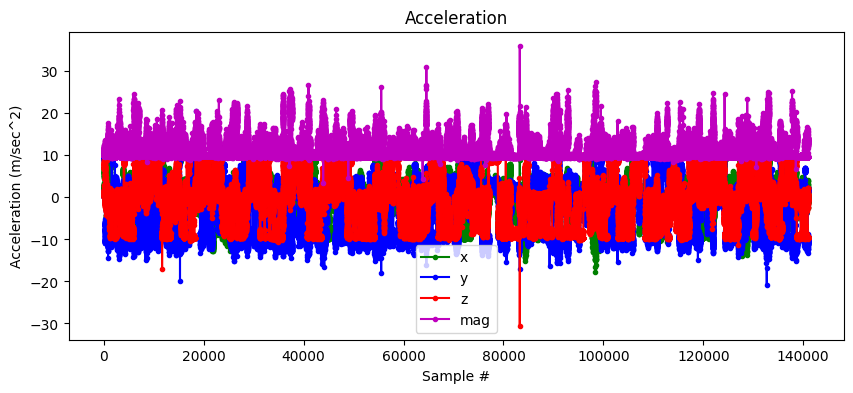

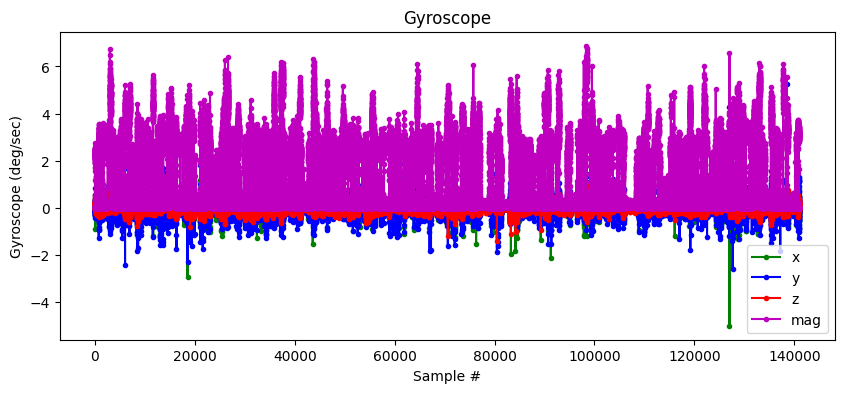

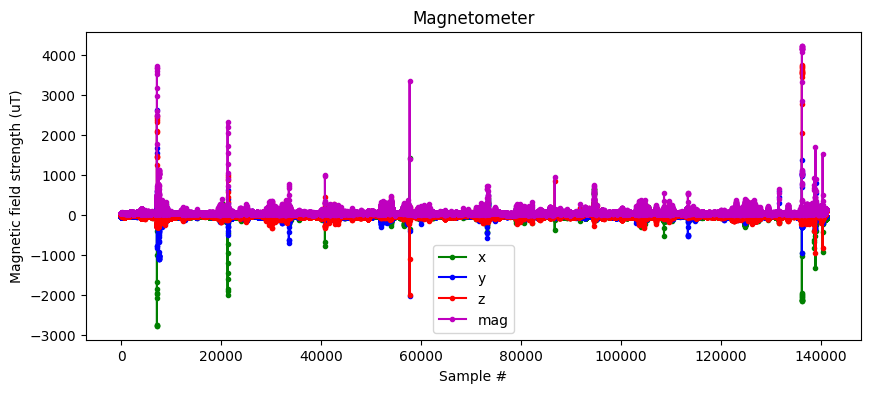

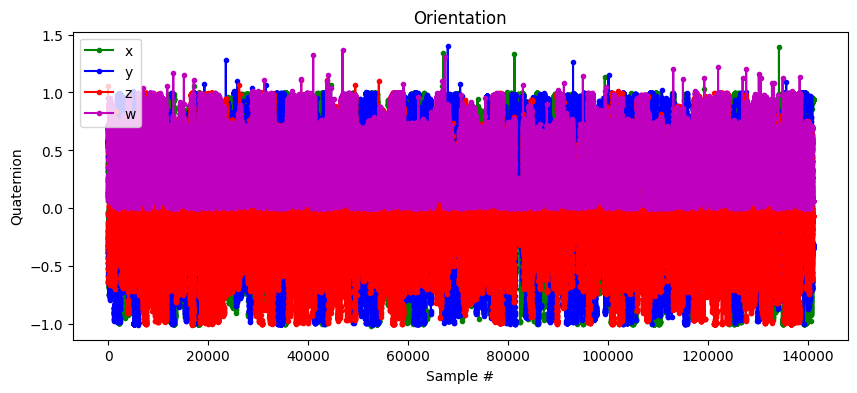

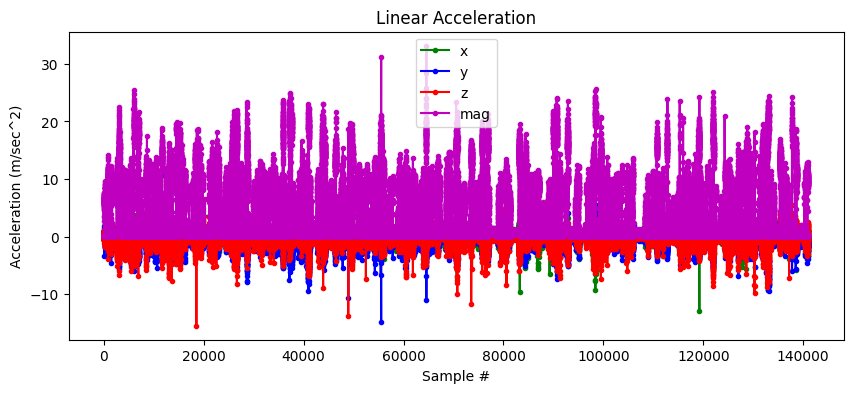

In [4]:
df_x = pd.read_csv("hips_motion_cleaned.csv")
df_y = pd.read_csv("label_cleaned.csv")

# Barometer is not working / non-existent on my phone
df_x = df_x.drop(['pressure'], axis=1)

index = range(1, len(df_x['accX']) + 1)

plt.rcParams["figure.figsize"] = (10,4)

plt.plot(index, df_x['accX'], 'g.', label='x', linestyle='solid')
plt.plot(index, df_x['accY'], 'b.', label='y', linestyle='solid')
plt.plot(index, df_x['accZ'], 'r.', label='z', linestyle='solid')
plt.plot(index, df_x['accMag'], 'm.', label='mag', linestyle='solid')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (m/sec^2)")
plt.legend()
plt.show()

plt.plot(index, df_x['gyroX'], 'g.', label='x', linestyle='solid')
plt.plot(index, df_x['gyroY'], 'b.', label='y', linestyle='solid')
plt.plot(index, df_x['gyroZ'], 'r.', label='z', linestyle='solid')
plt.plot(index, df_x['gyroMag'], 'm.', label='mag', linestyle='solid')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

plt.plot(index, df_x['magX'], 'g.', label='x', linestyle='solid')
plt.plot(index, df_x['magY'], 'b.', label='y', linestyle='solid')
plt.plot(index, df_x['magZ'], 'r.', label='z', linestyle='solid')
plt.plot(index, df_x['magMag'], 'm.', label='mag', linestyle='solid')
plt.title("Magnetometer")
plt.xlabel("Sample #")
plt.ylabel("Magnetic field strength (uT)")
plt.legend()
plt.show()

plt.plot(index, df_x['orientX'], 'g.', label='x', linestyle='solid')
plt.plot(index, df_x['orientY'], 'b.', label='y', linestyle='solid')
plt.plot(index, df_x['orientZ'], 'r.', label='z', linestyle='solid')
plt.plot(index, df_x['orientW'], 'm.', label='w', linestyle='solid')
plt.title("Orientation")
plt.xlabel("Sample #")
plt.ylabel("Quaternion")
plt.legend()
plt.show()

plt.plot(index, df_x['linAccX'], 'g.', label='x', linestyle='solid')
plt.plot(index, df_x['linAccY'], 'b.', label='y', linestyle='solid')
plt.plot(index, df_x['linAccZ'], 'r.', label='z', linestyle='solid')
plt.plot(index, df_x['linAccMag'], 'm.', label='mag', linestyle='solid')
plt.title("Linear Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (m/sec^2)")
plt.legend()
plt.show()

### Compare recorded data to SHL

In [5]:
def profileInput(input, output):
    # Get the unique classes in output_data
    classes = np.unique(output)

    # Calculate the mean of input_data for each class
    means = []
    std_devs = []
    for class_label in classes:
        class_indices = np.where(output == class_label)
        class_input_data = input[class_indices]
        class_mean = np.mean(class_input_data, axis=0)
        class_std_dev = np.std(class_input_data, axis=0)
        means.append(class_mean)
        std_devs.append(class_std_dev)
    return means, std_devs

## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

HUAWEI MATE 9 used in SHL dataset. Device HW should be according to: http://deviceinfohw.ru/devices/item.php?item=80167


TensorFlow version = 2.12.0

(8, 20)


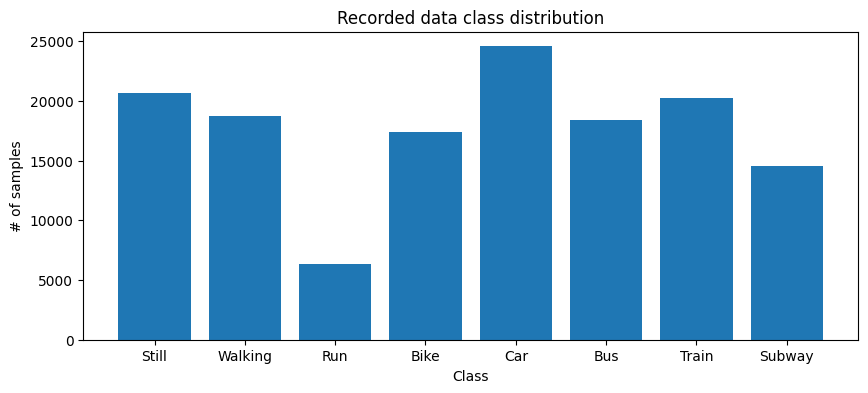

inputs.shape:  (141017, 20)


In [7]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of transportation modes that data is available for
# Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
TRANSPORT_MODES = [
    "Still",
    "Walking",
    "Run",
    "Bike",
    "Car",
    "Bus",
    "Train",
    "Subway"
]
NUM_MODES = len(TRANSPORT_MODES)

FEATURE_NAMES = [
    "accX","accY","accZ",
    "gyroX","gyroY","gyroZ",
    "magX","magY","magZ",
    "orientW","orientX","orientY","orientZ",
    "linAccX","linAccY","linAccZ",
    "accMag","gyroMag","magMag","linAccMag"
]

# Compute mean and std_dev of data per class
inputs = np.array(df_x, dtype='float32')
outputs = np.array(df_y['label'], dtype='float32')
shl_means, shl_std_devs = profileInput(inputs, outputs)
shl_means = np.array(shl_means, dtype='float32')
shl_std_devs = np.array(shl_std_devs, dtype='float32')
print(shl_means.shape)

# Bar chart representing SHL class distribution
unique_classes, samples_per_class = np.unique(outputs, return_counts=True)
plt.figure(figsize = (10,4))
plt.bar(TRANSPORT_MODES, samples_per_class)
plt.title('Recorded data class distribution')
plt.xlabel('Class')
plt.ylabel('# of samples')
plt.show()

# Normalize data
maxVals = df_x.max()
minVals = df_x.min()

df_x_norm = (df_x-df_x.min())/(df_x.max()-df_x.min())

# One-hot encoding
text_df_y = []
for i in range(0, len(df_y['label'])):
  text_df_y.append(df_y['label'][i])
df_y_ohe = pd.get_dummies(text_df_y)

# convert the list to numpy array
outputs = np.array(df_y_ohe, dtype='float32')

print("inputs.shape: ", inputs.shape)

In [ ]:
# Principal Component Analysis ( NOT INU USE )
pca = PCA(n_components=6, random_state=1)
inputs_reduced = pca.fit_transform(inputs) # Fit the model with features, and apply the transformation on the features.

explained_var = sum(pca.explained_variance_ratio_)*100 # Calculate the percentage of variance explained
print(f'Explained variance: {explained_var}')

#inputs  = inputs_reduced
print("inputs.shape: ", inputs.shape)

Explained variance: 99.69593826521243
inputs.shape:  (141017, 20)


In [10]:
# Make sequential samples
SEQSAMPLES = 3 # How many time-windows in the past to use

sub = SEQSAMPLES-1
seqInputs = np.zeros((inputs.shape[0]-sub, SEQSAMPLES, inputs.shape[1]), dtype='float32')
for i in range(sub, inputs.shape[0]):
  seqInputs[i-sub] = inputs[i-sub:i+1]

inputs = seqInputs
outputs = outputs[SEQSAMPLES-1:]

print("inputs.shape: ", inputs.shape)
print("Data set parsing and preparation complete.")

inputs.shape:  (141015, 3, 20)
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 80% for training, 10% for validation, and 10% for testing.

In [11]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation

num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
inputs = inputs.reshape(inputs.shape[0], SEQSAMPLES, inputs.shape[2])
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.8 * num_inputs)
TEST_SPLIT = int(0.1 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])
print(inputs_train.shape)
print("Data set randomization and splitting complete.")

(112812, 3, 20)
Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [12]:
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQSAMPLES, inputs_train.shape[2])),
    tf.keras.layers.LSTM(32, unroll=False, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_MODES, activation='softmax')
])

In [13]:
# Training parameters
num_epochs = 200
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=30, restore_best_weights=True)
lr_values = [1e-3, 5e-4]
lr_boundaries = [num_inputs/2]
lr_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(lr_boundaries, lr_values)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_fn)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

# Train the model
history = model.fit(inputs_train, outputs_train, epochs=num_epochs, batch_size=256, validation_data=(inputs_validate, outputs_validate), callbacks=[es])

Epoch 1/200
441/441 [==============================] - 11s 8ms/step - loss: 1.4000 - mae: 0.1693 - accuracy: 0.4797 - val_loss: 0.9400 - val_mae: 0.1267 - val_accuracy: 0.6627
Epoch 2/200
441/441 [==============================] - 2s 5ms/step - loss: 0.8339 - mae: 0.1112 - accuracy: 0.6913 - val_loss: 0.6813 - val_mae: 0.0937 - val_accuracy: 0.7594
Epoch 3/200
441/441 [==============================] - 3s 8ms/step - loss: 0.6827 - mae: 0.0914 - accuracy: 0.7498 - val_loss: 0.6004 - val_mae: 0.0814 - val_accuracy: 0.7833
Epoch 4/200
441/441 [==============================] - 3s 6ms/step - loss: 0.6237 - mae: 0.0829 - accuracy: 0.7736 - val_loss: 0.5604 - val_mae: 0.0765 - val_accuracy: 0.8063
Epoch 5/200
441/441 [==============================] - 3s 7ms/step - loss: 0.5831 - mae: 0.0774 - accuracy: 0.7885 - val_loss: 0.5261 - val_mae: 0.0707 - val_accuracy: 0.8131
Epoch 6/200
441/441 [==============================] - 3s 6ms/step - loss: 0.5534 - mae: 0.0733 - accuracy: 0.7995 - val_los

## Verify

Graph the models performance vs validation.


In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             6784      
                                                                 
 dropout (Dropout)           (None, 3, 32)             0         
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 8)                 776       
                                                                 
Total params: 7,560
Trainable params: 7,560
Non-trainable params: 0
_________________________________________________________________
None


### Graph the loss

Graph the loss to see when the model stops improving.

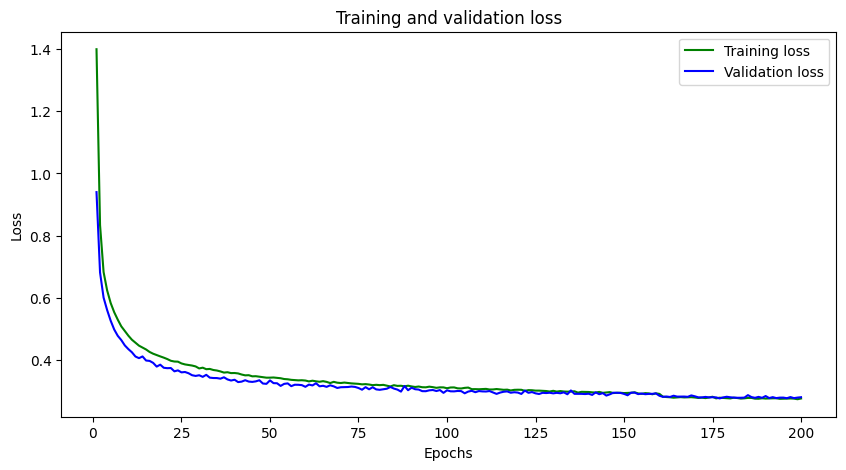

[10.0, 5.0]


In [15]:
plt.rcParams["figure.figsize"] = (10,5)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



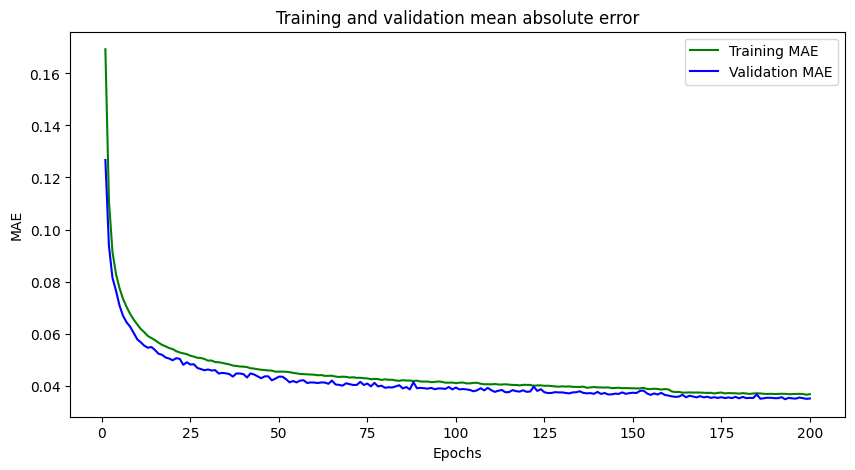

In [16]:
plt.rcParams["figure.figsize"] = (10,5)

# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[:], mae[:], 'g-', label='Training MAE')
plt.plot(epochs[:], val_mae[:], 'b-', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Graph the accuracy

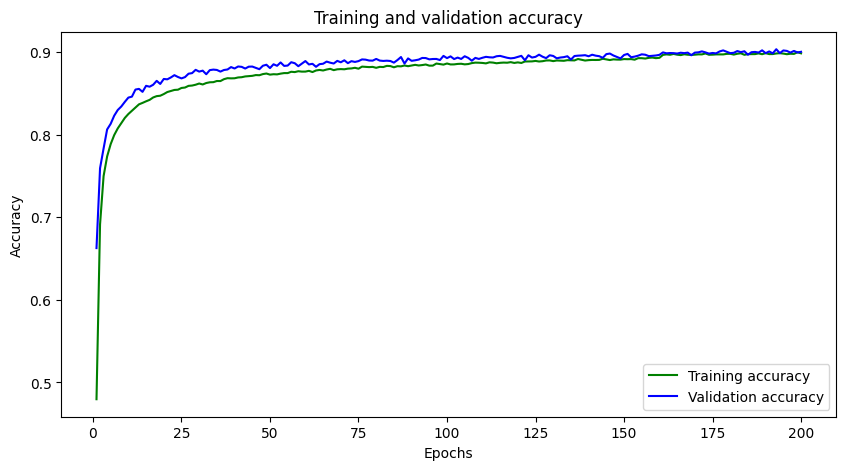

[10.0, 5.0]


In [17]:
plt.rcParams["figure.figsize"] = (10,5)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'g-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Run with Test Data
Put our test data into the model and plot the predictions


In [18]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
predictions_round = np.round(predictions, decimals=0)

loss, mae, acc = model.evaluate(inputs_test, outputs_test)
print("Test Loss: {:.4f}".format(loss))
print("Test MAE: {:.4f}".format(mae))
print("Test accuracy: {:.4f}".format(acc))

# print the predictions and the expected ouputs
#print("predictions =\n", predictions_round)
#print("actual =\n", outputs)

mistake_counter = 0
for i in range(len(predictions_round)):
  for j in range(len(predictions_round[1])):
    if predictions_round[i][j] != outputs_test[i][j]:
      mistake_counter += 1
      break

print("Correct predictions: {0} out of {1} = {2} %".format((len(outputs_test) - mistake_counter), len(outputs_test), 100*((len(outputs_test) - mistake_counter)/len(outputs_test))))

441/441 [==============================] - 1s 3ms/step - loss: 0.2862 - mae: 0.0356 - accuracy: 0.8958
Test Loss: 0.2862
Test MAE: 0.0356
Test accuracy: 0.8958
Correct predictions: 12448 out of 14101 = 88.27742713282746 %


[Text(0.5, 47.7222222222222, 'Predicted transport mode'),
 Text(95.72222222222221, 0.5, 'Actual transport mode'),
 Text(0.5, 1.0, 'Confusion matrix')]

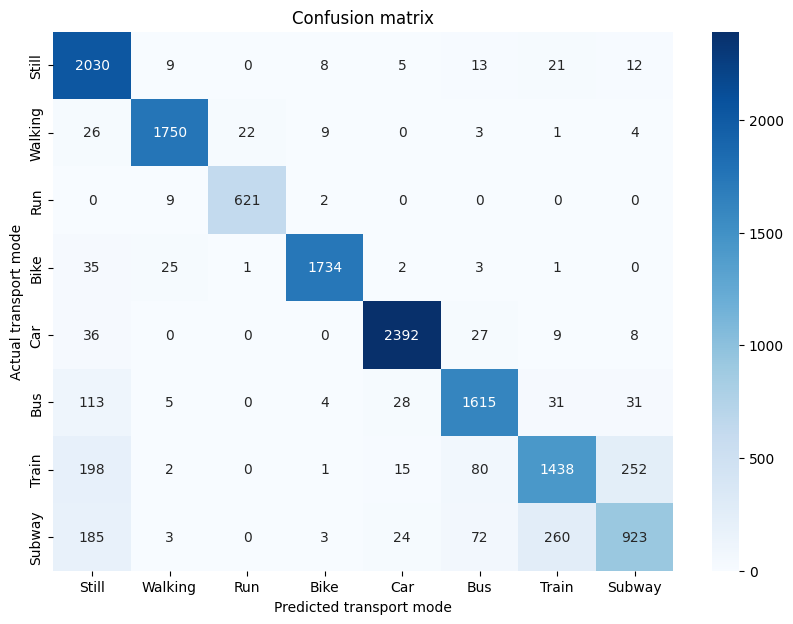

In [19]:
outputs_n = []
predictions_n = np.zeros(outputs_test.shape[0])
for i in range(outputs_test.shape[0]):
  for j in range(outputs_test.shape[1]):
    if(outputs_test[i][j] == 1):
      outputs_n.append(j)
    if(predictions_round[i][j] > predictions_n[i]):
      predictions_n[i] = j

cfm = confusion_matrix(outputs_n, predictions_n)

df_cm = pd.DataFrame(cfm, index = TRANSPORT_MODES,
                  columns = TRANSPORT_MODES)
plt.figure(figsize = (10,7))
hm = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
hm.set(xlabel='Predicted transport mode', ylabel='Actual transport mode', title='Confusion matrix')

## Prepare recorded data

[0 1 2 3 4 5 6 7]
[0, 1, 2, 3, 5, 7]
[4, 6]


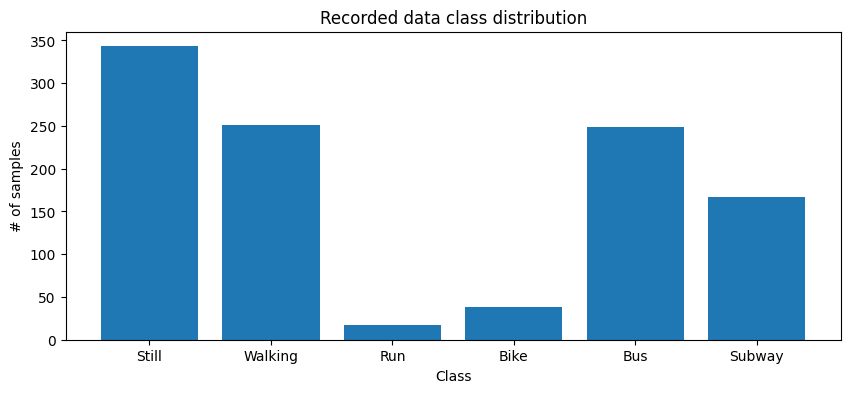

recInputs.shape:  (1065, 20)
recOutputs.shape:  (1065, 8)


In [20]:
df_rec_x = pd.read_csv("recorded_final.csv", sep=',',  encoding='utf-8')
df_rec_y = pd.read_csv("labels_final.csv")

# calculate maean and std dev of data per class
recInputs = np.array(df_rec_x, dtype='float32')
recOutputs = np.array(df_rec_y['label'], dtype='float32')
rec_means, rec_std_devs = profileInput(recInputs, recOutputs)
rec_means = np.array(rec_means, dtype='float32')
rec_std_devs = np.array(rec_std_devs, dtype='float32')
all_classes = np.arange(0, NUM_MODES,1)
print(all_classes)
present_classes = np.unique(recOutputs).astype(int)
present_classes = [cl - 1 for cl in present_classes]
print(present_classes)
non_present_classes = [cl for cl in all_classes if cl not in present_classes]
print(non_present_classes)

#Remove classes not present in recorded data
present_labels = np.array(TRANSPORT_MODES)
present_labels = present_labels[present_classes]
shl_means_present = shl_means[present_classes]
shl_std_devs_present = shl_std_devs[present_classes]

# Bar chart representing recorded data distribution
unique_classes, samples_per_class = np.unique(recOutputs, return_counts=True)
plt.figure(figsize = (10,4))
plt.bar(present_labels, samples_per_class)
plt.title('Recorded data class distribution')
plt.xlabel('Class')
plt.ylabel('# of samples')
plt.show()

# Normalize data
maxVals = df_rec_x.max()
minVals = df_rec_x.min()

df_rec_x_norm = (df_rec_x-df_rec_x.min())/(df_rec_x.max()-df_rec_x.min())

# One-hot encoding
text_df_rec_y = []
for i in range(0, len(df_rec_y['label'])):
  text_df_rec_y.append(df_rec_y['label'][i])
df_rec_y_ohe = pd.get_dummies(text_df_rec_y)

# convert the list to numpy array
recOutputs = np.array(df_rec_y_ohe, dtype='float32')
for i in range(len(non_present_classes)):
    recOutputs = np.insert(recOutputs, non_present_classes[i], np.zeros((1, recOutputs.shape[0])), axis=1)

print("recInputs.shape: ", recInputs.shape)
print("recOutputs.shape: ", recOutputs.shape)

[Text(0.5, 58.7222222222222, 'feature'),
 Text(220.72222222222223, 0.5, 'Class'),
 Text(0.5, 1.0, 'Dataset standard deviation difference')]

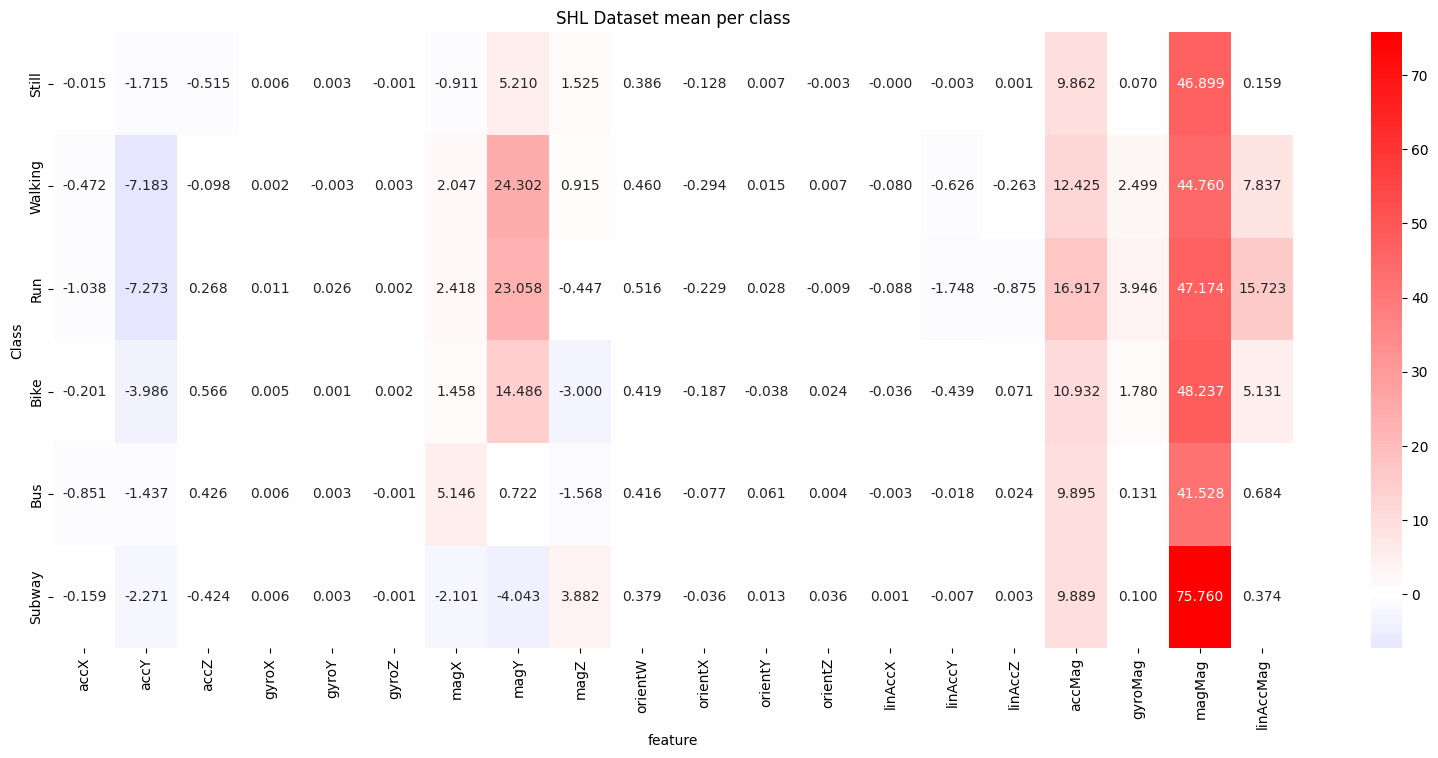

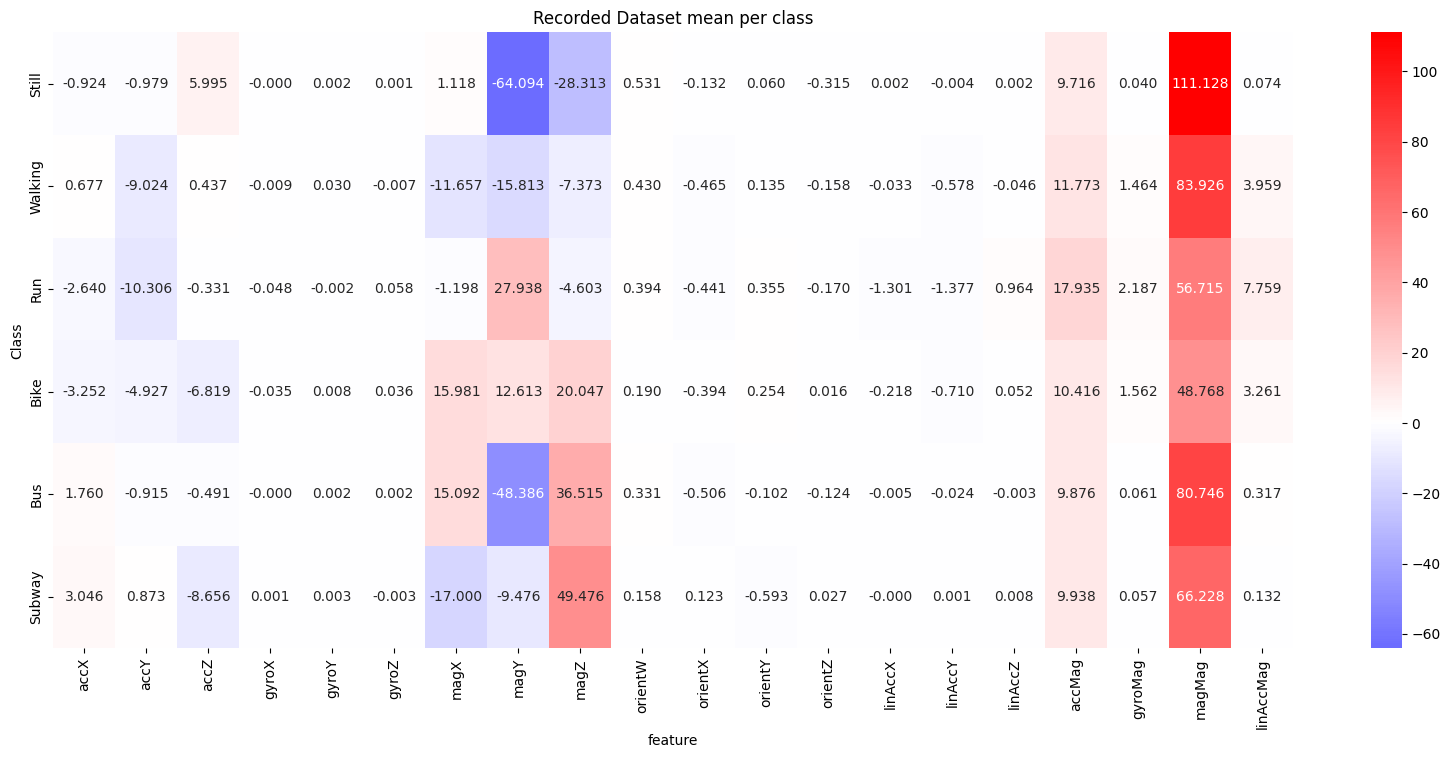

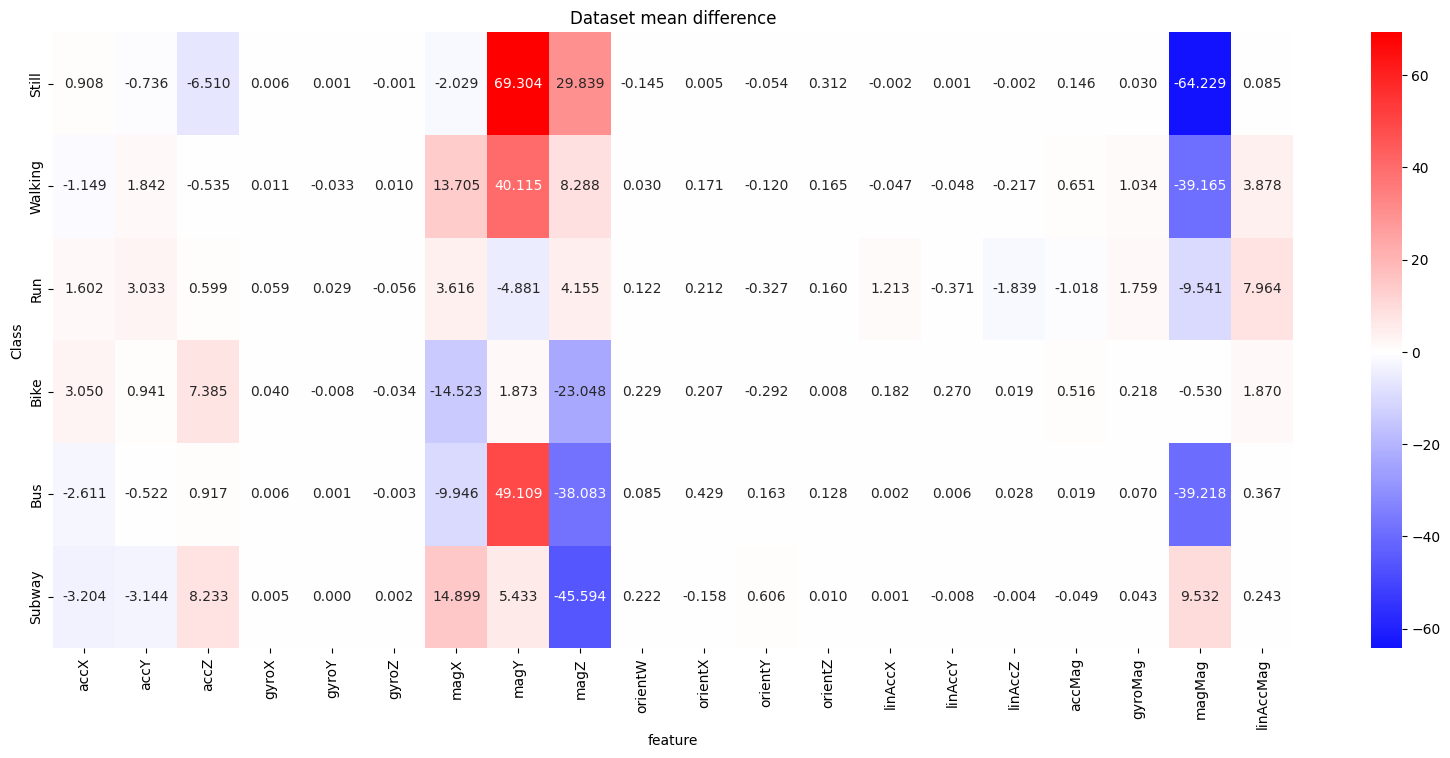

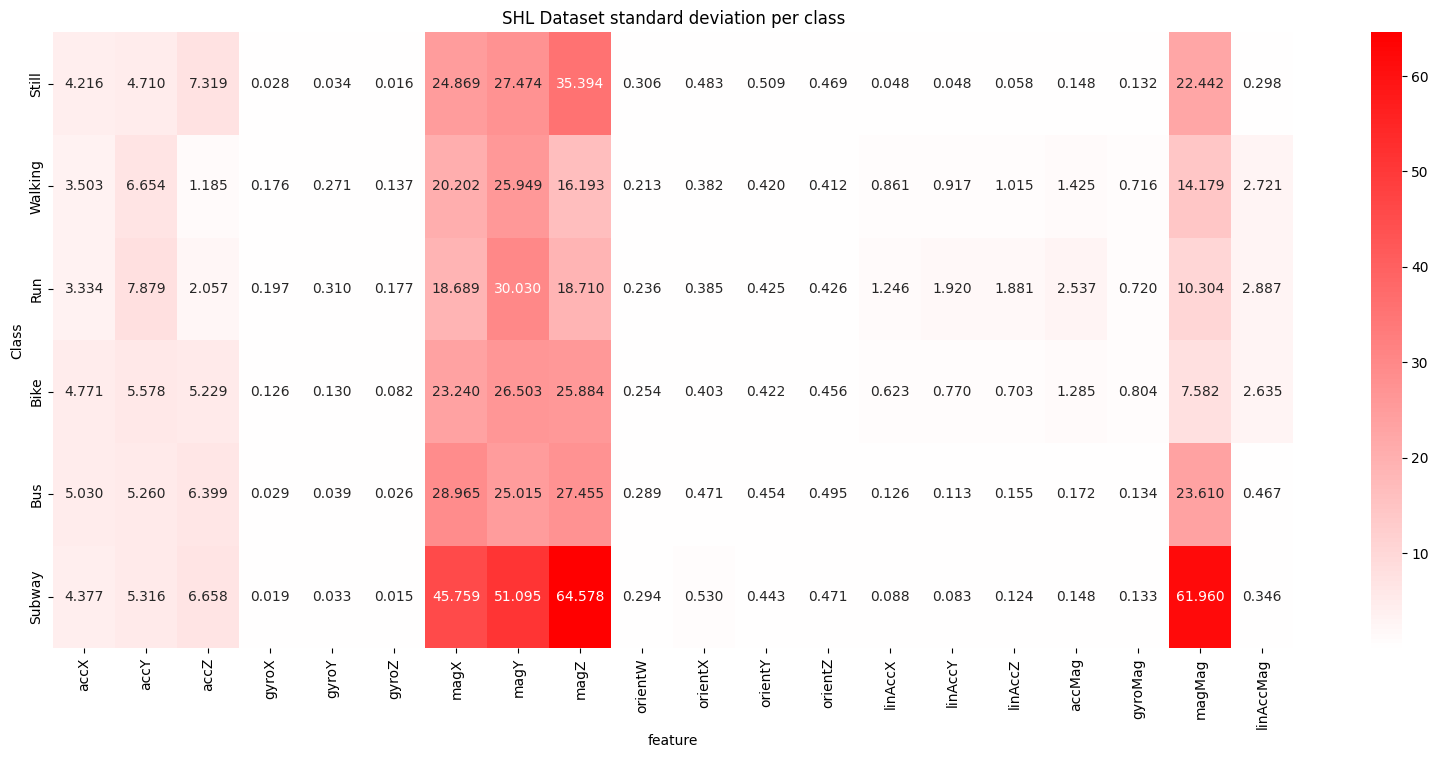

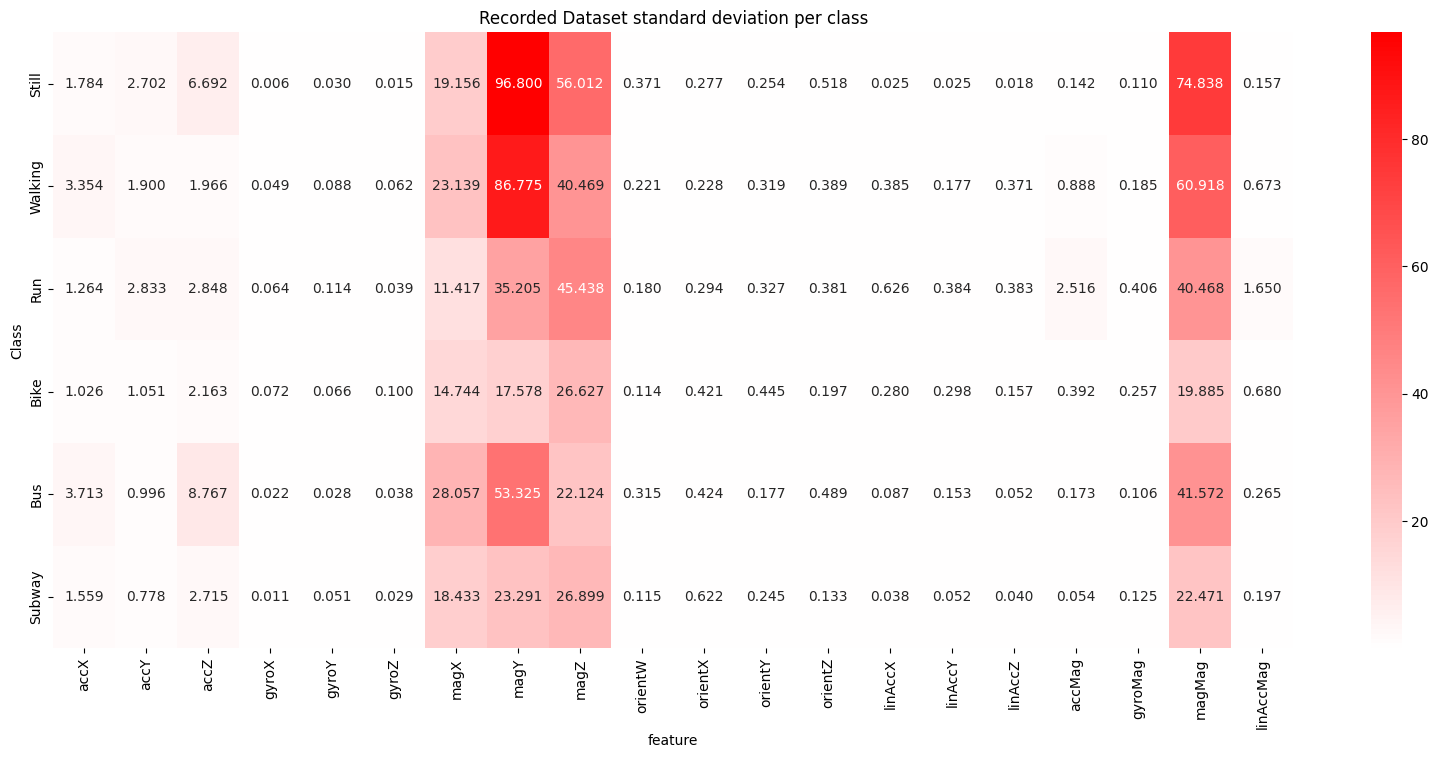

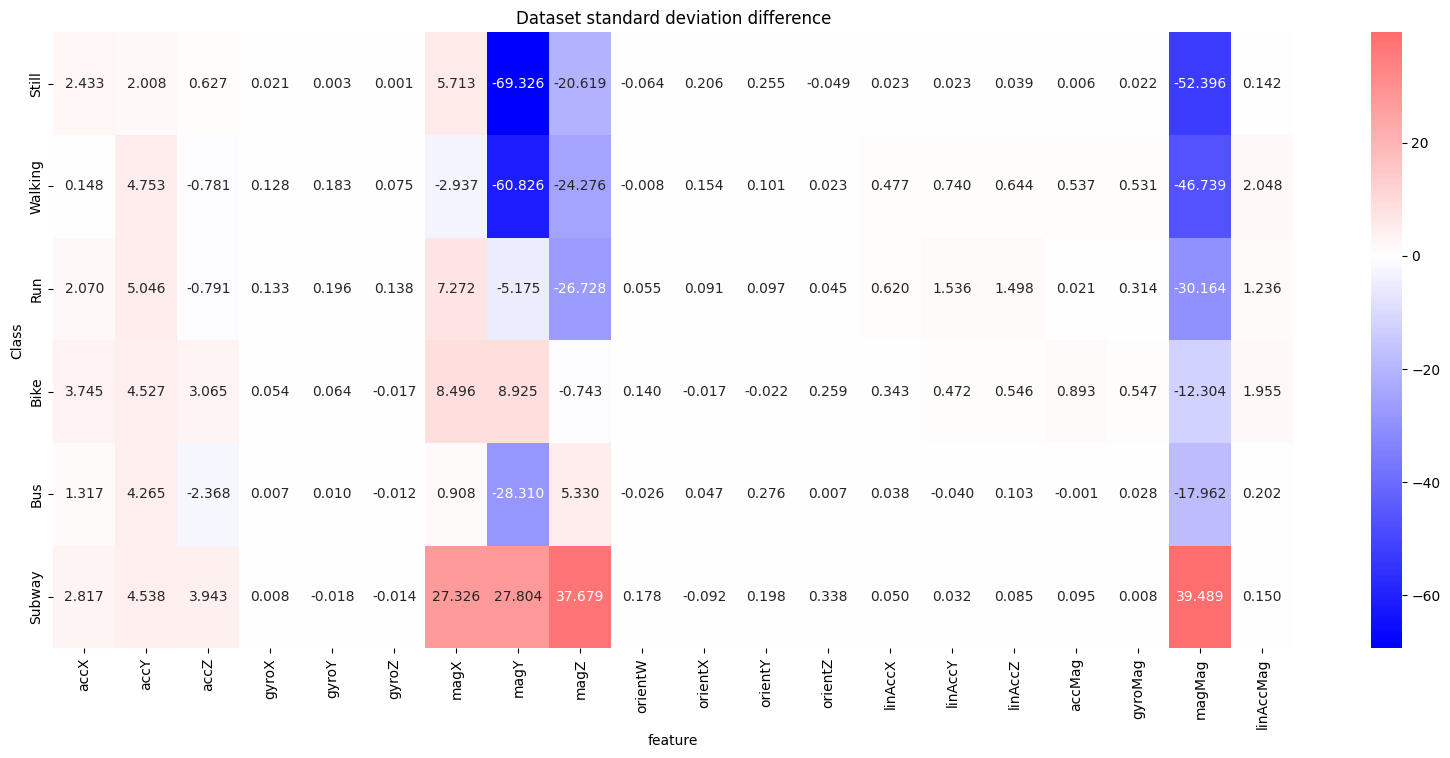

In [21]:
# Create colormap for comparison
mean_diff = shl_means_present - rec_means
std_dev_diff = shl_std_devs_present - rec_std_devs

# Mean
df_mean_shl = pd.DataFrame(shl_means_present, index = present_labels,
                  columns = FEATURE_NAMES)
plt.figure(figsize = (20,8))
hm_shl_mean = sn.heatmap(df_mean_shl, annot=True, cmap=plt.cm.bwr, center=0.00, fmt='.3f')
hm_shl_mean.set(xlabel='feature', ylabel='Class', title='SHL Dataset mean per class')

df_mean_rec = pd.DataFrame(rec_means, index = present_labels,
                  columns = FEATURE_NAMES)
plt.figure(figsize = (20,8))
hm_rec_mean = sn.heatmap(df_mean_rec, annot=True, cmap=plt.cm.bwr, center=0.00, fmt='.3f')
hm_rec_mean.set(xlabel='feature', ylabel='Class', title='Recorded Dataset mean per class')

df_mean_comp = pd.DataFrame(mean_diff, index = present_labels,
                  columns = FEATURE_NAMES)
plt.figure(figsize = (20,8))
hm_mean = sn.heatmap(df_mean_comp, annot=True, cmap=plt.cm.bwr, center=0.00, fmt='.3f')
hm_mean.set(xlabel='feature', ylabel='Class', title='Dataset mean difference')

# Standard deviation
df_std_dev_shl = pd.DataFrame(shl_std_devs_present, index = present_labels,
                  columns = FEATURE_NAMES)
plt.figure(figsize = (20,8))
hm_shl_sd = sn.heatmap(df_std_dev_shl, annot=True, cmap=plt.cm.bwr, center=0.00, fmt='.3f')
hm_shl_sd.set(xlabel='feature', ylabel='Class', title='SHL Dataset standard deviation per class')

df_std_dev_rec = pd.DataFrame(rec_std_devs, index = present_labels,
                  columns = FEATURE_NAMES)
plt.figure(figsize = (20,8))
hm_rec_sd = sn.heatmap(df_std_dev_rec, annot=True, cmap=plt.cm.bwr, center=0.00, fmt='.3f')
hm_rec_sd.set(xlabel='feature', ylabel='Class', title='Recorded Dataset standard deviation per class')

df_std_dev_comp = pd.DataFrame(std_dev_diff, index = present_labels,
                  columns = FEATURE_NAMES)
plt.figure(figsize = (20,8))
hm_sd = sn.heatmap(df_std_dev_comp, annot=True, cmap=plt.cm.bwr, center=0.00, fmt='.3f')
hm_sd.set(xlabel='feature', ylabel='Class', title='Dataset standard deviation difference')


In [22]:
seqRecInputs = np.zeros((recInputs.shape[0]-sub, SEQSAMPLES, recInputs.shape[1]), dtype='float32')
for i in range(sub, recInputs.shape[0]):
  seqRecInputs[i-sub] = recInputs[i-sub:i+1]

recInputs = seqRecInputs
recOutputs = recOutputs[SEQSAMPLES-1:]

print("recInputs.shape: ", recInputs.shape)
print("recOutputs.shape: ", recOutputs.shape)
print("Data set parsing and preparation complete.")

recInputs.shape:  (1063, 3, 20)
recOutputs.shape:  (1063, 8)
Data set parsing and preparation complete.


In [23]:
# Randomize the order of the recorded inputs, so they can be evenly distributed for training, testing, and validation

num_rec_inputs = len(recInputs)
randomize = np.arange(num_rec_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
recInputs = recInputs[randomize]
recInputs = recInputs.reshape(recInputs.shape[0], SEQSAMPLES, recInputs.shape[2])
recOutputs = recOutputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.8 * num_rec_inputs)
TEST_SPLIT = int(0.1 * num_rec_inputs + TRAIN_SPLIT)

inputs_rec_train, inputs_rec_test, inputs_rec_validate = np.split(recInputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_rec_train, outputs_rec_test, outputs_rec_validate = np.split(recOutputs, [TRAIN_SPLIT, TEST_SPLIT])

print("inputs_rec_train.shape: ", inputs_rec_train.shape)
print("outputs_rec_train.shape: ", outputs_rec_train.shape)
print("inputs_rec_test.shape: ", inputs_rec_test.shape)
print("outputs_rec_test.shape: ", outputs_rec_test.shape)
print("inputs_rec_validate.shape: ", inputs_rec_validate.shape)
print("outputs_rec_validate.shape: ", outputs_rec_validate.shape)

print("Data set randomization and splitting complete.")

inputs_rec_train.shape:  (850, 3, 20)
outputs_rec_train.shape:  (850, 8)
inputs_rec_test.shape:  (106, 3, 20)
outputs_rec_test.shape:  (106, 8)
inputs_rec_validate.shape:  (107, 3, 20)
outputs_rec_validate.shape:  (107, 8)
Data set randomization and splitting complete.


## Run with recorded data
Before adapting the network to our own data

In [24]:
# use the pre-trained model to predict the recorded test inputs
rec_predictions = model.predict(recInputs)
rec_predictions_round = np.round(rec_predictions, decimals=0)

loss, mae, acc = model.evaluate(recInputs, recOutputs)
print("Test Loss: {:.4f}".format(loss))
print("Test MAE: {:.4f}".format(mae))
print("Test accuracy: {:.4f}".format(acc))

# print the predictions and the expected ouputs
#print("predictions =\n", predictions_round)
#print("actual =\n", outputs)
print(len(rec_predictions_round))
print(len(rec_predictions_round[1]))

rec_mistake_counter = 0
for i in range(len(rec_predictions_round)):
  for j in range(len(rec_predictions_round[1])):
    if rec_predictions_round[i][j] != recOutputs[i][j]:
      rec_mistake_counter += 1
      break

print("Correct predictions: {0} out of {1} = {2} %".format((len(recOutputs) - rec_mistake_counter), len(recOutputs), 100*((len(recOutputs) - rec_mistake_counter)/len(recOutputs))))

34/34 [==============================] - 0s 3ms/step - loss: 2.4094 - mae: 0.1327 - accuracy: 0.4779
Test Loss: 2.4094
Test MAE: 0.1327
Test accuracy: 0.4779
1063
8
Correct predictions: 495 out of 1063 = 46.566321730950136 %



[0 1 3 4 5 6 7]


[Text(0.5, 47.7222222222222, 'Predicted transport mode'),
 Text(95.72222222222221, 0.5, 'Actual transport mode'),
 Text(0.5, 1.0, 'Confusion matrix')]

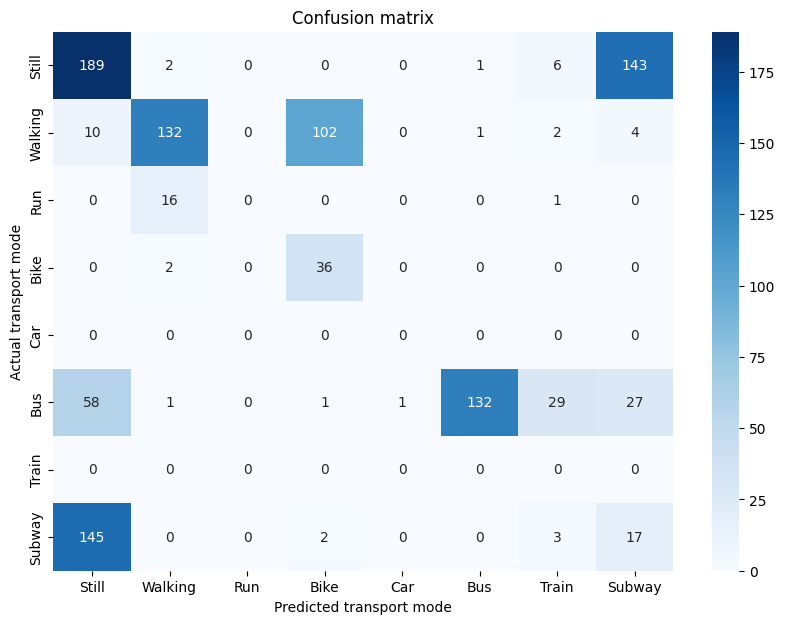

In [26]:
outputs_rec_n = []
predictions_rec_n = np.zeros(recOutputs.shape[0])
for i in range(recOutputs.shape[0]):
  for j in range(recOutputs.shape[1]):
    if(recOutputs[i][j] == 1):
      outputs_rec_n.append(j)
    if(rec_predictions_round[i][j] > predictions_rec_n[i]):
      predictions_rec_n[i] = j
print(f"")

nonzero_index = np.where(np.any(rec_predictions_round != 0, axis=0))[0]
print(nonzero_index)
all_modes = np.array(TRANSPORT_MODES)
present_labels_pre = all_modes[nonzero_index]

cfm = confusion_matrix(outputs_rec_n, predictions_rec_n)

df_rec_cm = pd.DataFrame(cfm, index = TRANSPORT_MODES,
                  columns = TRANSPORT_MODES)
plt.figure(figsize = (10,7))
hm = sn.heatmap(df_rec_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
hm.set(xlabel='Predicted transport mode', ylabel='Actual transport mode', title='Confusion matrix')

## Retrain model with user data

In [27]:
es_refit = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=50, restore_best_weights=True)
history = model.fit(inputs_rec_train, outputs_rec_train, epochs=50, batch_size=64, validation_data=(inputs_rec_validate, outputs_rec_validate), callbacks=[es_refit])

Epoch 1/50
14/14 [==============================] - 0s 10ms/step - loss: 1.0933 - mae: 0.0793 - accuracy: 0.7282 - val_loss: 0.8447 - val_mae: 0.0508 - val_accuracy: 0.8224
Epoch 2/50
14/14 [==============================] - 0s 8ms/step - loss: 0.4081 - mae: 0.0408 - accuracy: 0.8859 - val_loss: 0.5046 - val_mae: 0.0425 - val_accuracy: 0.8785
Epoch 3/50
14/14 [==============================] - 0s 8ms/step - loss: 0.2378 - mae: 0.0332 - accuracy: 0.9294 - val_loss: 0.3514 - val_mae: 0.0322 - val_accuracy: 0.9252
Epoch 4/50
14/14 [==============================] - 0s 8ms/step - loss: 0.2077 - mae: 0.0265 - accuracy: 0.9412 - val_loss: 0.3214 - val_mae: 0.0289 - val_accuracy: 0.9346
Epoch 5/50
14/14 [==============================] - 0s 8ms/step - loss: 0.1741 - mae: 0.0238 - accuracy: 0.9518 - val_loss: 0.3039 - val_mae: 0.0273 - val_accuracy: 0.9252
Epoch 6/50
14/14 [==============================] - 0s 8ms/step - loss: 0.1618 - mae: 0.0219 - accuracy: 0.9529 - val_loss: 0.3037 - val_ma

## Run with recorded data
After re-fitting the network

In [28]:
# use the pre-trained model to predict the recorded inputs
rec_predictions = model.predict(inputs_rec_test)
rec_predictions_round = np.round(rec_predictions, decimals=0)

loss, mae, acc = model.evaluate(inputs_rec_test, outputs_rec_test)
print("Test Loss: {:.4f}".format(loss))
print("Test MAE: {:.4f}".format(mae))
print("Test accuracy: {:.4f}".format(acc))

# print the predictions and the expected ouputs
#print("predictions =\n", predictions_round)
#print("actual =\n", outputs)
print(len(rec_predictions_round))
print(len(rec_predictions_round[1]))

rec_mistake_counter = 0
for i in range(len(rec_predictions_round)):
  for j in range(len(rec_predictions_round[1])):
    if rec_predictions_round[i][j] != outputs_rec_test[i][j]:
      rec_mistake_counter += 1
      break

print("Correct predictions: {0} out of {1} = {2} %".format((len(outputs_rec_test) - rec_mistake_counter), len(outputs_rec_test), 100*((len(outputs_rec_test) - rec_mistake_counter)/len(outputs_rec_test))))

4/4 [==============================] - 0s 5ms/step - loss: 0.0261 - mae: 0.0052 - accuracy: 0.9906
Test Loss: 0.0261
Test MAE: 0.0052
Test accuracy: 0.9906
106
8
Correct predictions: 105 out of 106 = 99.05660377358491 %


[Text(0.5, 47.7222222222222, 'Predicted transport mode'),
 Text(95.72222222222221, 0.5, 'Actual transport mode'),
 Text(0.5, 1.0, 'Confusion matrix')]

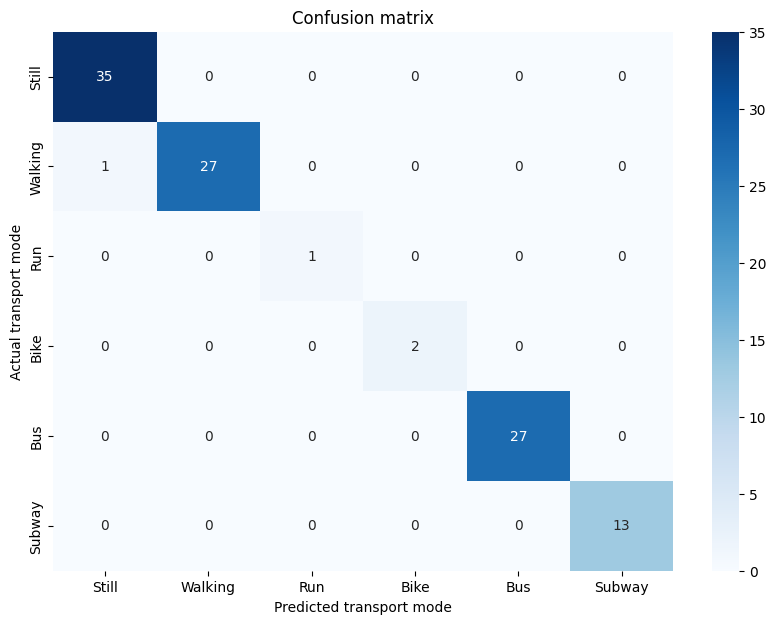

In [29]:
outputs_rec_n = []
predictions_rec_n = np.zeros(outputs_rec_test.shape[0])
for i in range(outputs_rec_test.shape[0]):
  for j in range(outputs_rec_test.shape[1]):
    if(outputs_rec_test[i][j] == 1):
      outputs_rec_n.append(j)
    if(rec_predictions_round[i][j] > predictions_rec_n[i]):
      predictions_rec_n[i] = j

cfm_fit = confusion_matrix(outputs_rec_n, predictions_rec_n)

df_rec_fit_cm = pd.DataFrame(cfm_fit, index = present_labels,
                  columns = present_labels)
plt.figure(figsize = (10,7))
hm = sn.heatmap(df_rec_fit_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
hm.set(xlabel='Predicted transport mode', ylabel='Actual transport mode', title='Confusion matrix')

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = inputs_train.shape[1]
INPUT_SIZE = inputs_train.shape[2]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_TMD_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Save the model to disk
open("tmd_model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("tmd_model.tflite")
print("Model is %d bytes" % basic_model_size)


Model is 33384 bytes
